In [123]:
# TODO:
# - Handle emojis
# - Handle special characters (display '&' instead of "&amp;")
# - Remove HTML tags (like "<br>")
# - Translate text to english

# Finance News Sentiments Classifier

## Requirements

In [124]:
# `language_check` dependency must be used with Java 8
! sudo apt install openjdk-8-jdk -y
! sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

# Working version of `language_check`
! pip install git+https://github.com/MCFreddie777/language-check.git

! pip install POT # pycontractions dependency
! pip install contractions # For counting contractions
! pip install pycontractions # For expanding contractions

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-8-jdk is already the newest version (8u422-b05-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
  Cloning https://github.com/MCFreddie777/language-check.git to /tmp/pip-req-build-1v5qw7rc
  Running command git clone --filter=blob:none --quiet https://github.com/MCFreddie777/language-check.git /tmp/pip-req-build-1v5qw7rc
  Resolved https://github.com/MCFreddie777/language-check.git to commit 337493f25b5a49af0a09b0e264f306eccefaff8f
  Preparing metadata (setup.py) ... done


## Data Processing

### Dataset Retrieval

In [125]:
import pandas as pd
from pandas import DataFrame

dataset_path: str = "/kaggle/input/news-sentiment-analysis-for-stock-data-by-company/djia_news copy.csv/djia_news copy.csv"
column_names: list[str] = ["sentiment", "text"]
X: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace",
    usecols=[0, 2]
)
print(f"X shape: {X.shape}")
    
dataset_path: str = "/kaggle/input/news-sentiment-analysis-for-stock-data-by-company/nasdaq.csv/nasdaq.csv"
X1: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace",
    usecols=[0, 2]
)
print(f"X1 shape: {X1.shape}")
    
# Concatenate dataframes
X: DataFrame = pd.concat([X, X1])
print(f"Concatenated dataframe shape: {X.shape}")

# Map integers labels to string for data visualization
X["sentiment"] = X["sentiment"].map({
    0: "negative",
    1: "positive",
    2: "neutral"
})

# TODO: Remove links
X.sample(5)

X shape: (2381, 2)
X1 shape: (13181, 2)
Concatenated dataframe shape: (15562, 2)


,sentiment,text
12745,negative,How the US-China trade war is felt stateside: ...
5081,positive,Stone tool discovery pushes back dawn of cultu...
9411,negative,Listen to the 'impossible': 170-year-old aband...
6525,negative,The world’s first solar power station that can...
12278,negative,At least 30 journalists currently are reported...


In [126]:
dataset_path: str = "/kaggle/input/stockmarket-sentiment-dataset/stock_data.csv"
column_names: list[str] = ["text", "sentiment"]
X1: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)

# Reorder columns
X1: DataFrame = X1.reindex(columns=["sentiment", "text"])
X1.sample(5)

# Map integers labels to string for data visualization
X1.sentiment = X1.sentiment.map({
    -1: "negative",
    1: "positive",
})
X1.sample(5)

X: DataFrame = pd.concat([X, X1])
X.sample(5)

,sentiment,text
5772,negative,Greece ousted from index of 'developed' countr...
2745,positive,Wind power is now the cheapest electricity to ...
3159,negative,Government decides to allot DDA flat to Delhi ...
6848,negative,Hetero Enters License Agreement With Gilead Sc...
7120,negative,gopro hero 3 review


In [127]:
dataset_path: str = "/kaggle/input/twitter-financial-news-sentiment-dataset/sent_train.csv"
column_names: list[str] = ["text", "sentiment"]
X1: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)
    
dataset_path: str = "/kaggle/input/twitter-financial-news-sentiment-dataset/sent_valid.csv"
column_names: list[str] = ["text", "sentiment"]
X2: DataFrame = pd.read_csv(
    dataset_path,
    header=0,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)

X1: DataFrame = pd.concat([X1, X2])
X1.sample(5)

# Reorder columns
X1: DataFrame = X1.reindex(columns=["sentiment", "text"])
X1.sample(5)

# Map integers labels to string for data visualization
X1.sentiment = X1.sentiment.map({
    0: "negative",
    1: "positive",
    2: "neutral"
})
X1.sample(5)

# Concatenate dataframes
print(f"X shape: {X.shape}")
print(f"X1 shape: {X1.shape}")

X: DataFrame = pd.concat([X, X1])
print(f"Concatenated dataframe shape: {X.shape}")


X.sample(5)

X shape: (21353, 2)
X1 shape: (11931, 2)
Concatenated dataframe shape: (33284, 2)


,sentiment,text
5761,negative,Indian Stocks Crash To Worst Day Since 2008 As...
1538,neutral,Rupert Murdoch faces shareholder revolt at New...
3778,negative,Some Bad News From JPM: This Is What Happens A...
253,positive,Heat Biologics started at buy with $1 stock pr...
3879,positive,Spain arrests suspected al-Qaeda trio: Author...


In [128]:
dataset_path: str = "/kaggle/input/sentiment-analysis-for-financial-news/all-data.csv"
column_names: list[str] = ["sentiment", "text"]
X1: DataFrame = pd.read_csv(
    dataset_path,
    names=column_names,
    encoding="utf-8",
    encoding_errors="replace"
)
print(f"X shape: {X.shape}")
print(f"X1 shape: {X1.shape}")


# Concatenate dataframes
X: DataFrame = pd.concat([X, X1])
print(f"Concatenated dataframe shape: {X.shape}")

X.sample(5)

X shape: (33284, 2)
X1 shape: (4846, 2)
Concatenated dataframe shape: (38130, 2)


,sentiment,text
1232,negative,'J Street' a new liberal Jewish organization h...
8070,positive,RECAP 11/22 Unusual Calls:\n$CY Jan 20 C\n$CRO...
1632,neutral,Larry Ellison Hits the High Seas With Endeavor...
12002,negative,Venezuela may move billions of dollars of Gold...
3937,neutral,.@RevShark breaks down 3 things to be thankful...


### Data Cleaning

In [129]:
# Check for nulls
print("Nulls before dropping:", X.isnull().sum().sum())
print("Dropping nulls...")
X.dropna(inplace=True)
print("Nulls remaining:", X.isnull().sum().sum())

Nulls before dropping: 0
Dropping nulls...
Nulls remaining: 0


In [130]:
# Check for duplicates
print("Duplicates found:", X.text.duplicated().sum().sum())
print("Removing duplicates...")
X.drop_duplicates(subset=["text"], inplace=True)
print("Duplicates remaining:", X.text.duplicated().sum().sum())

Duplicates found: 4257
Removing duplicates...
Duplicates remaining: 0


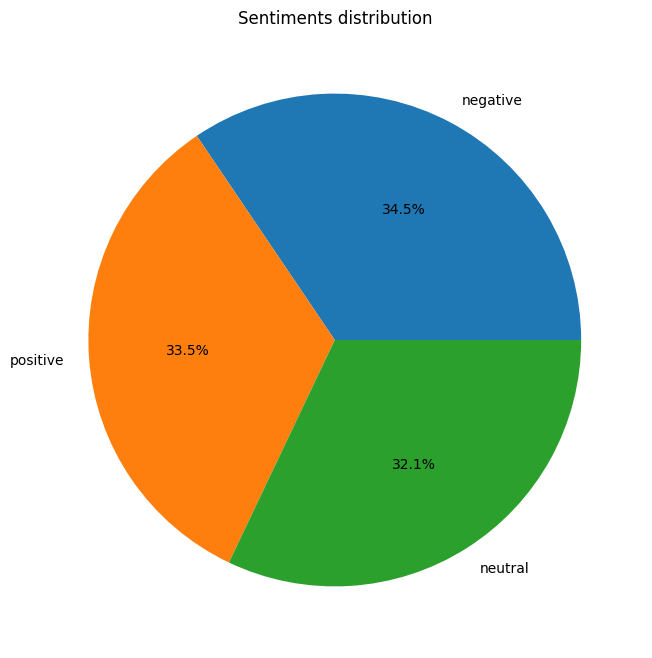

In [131]:
import matplotlib.pyplot as plt
from pandas import Series

label_counts: Series = X.sentiment.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Sentiments distribution')
plt.show()

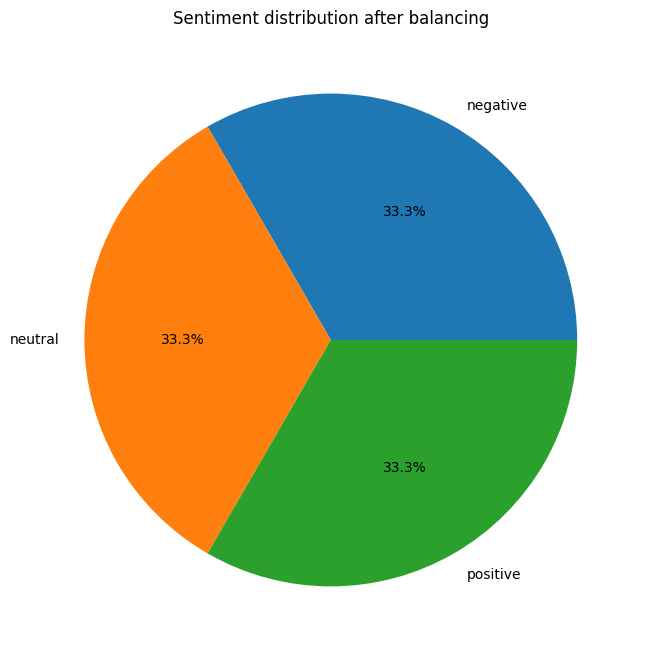

In [132]:
# Balance dataframe so that each sentiment has the same number of elements
min_label_count: int = label_counts.values[-1]
negative_sample: DataFrame = X[X.sentiment == "negative"].sample(min_label_count)
neutral_sample: DataFrame = X[X.sentiment == "neutral"].sample(min_label_count)
positive_sample: DataFrame = X[X.sentiment == "positive"].sample(min_label_count)
X: DataFrame = pd.concat([negative_sample, neutral_sample, positive_sample])

# Visualize sentiment distribution after balancing
label_counts: Series = X.sentiment.value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Sentiment distribution after balancing')
plt.show()

In [133]:
# Remove leading and trailing whitespaces and newlines characters
X.text.str.strip()

8347     New York City Council votes to limit number of...
1305     Turkish soldiers save wounded US intel agent o...
5583     Shopping Vintage on Etsy (Tips &amp; Tricks Too!)
10290    The UK is about to start enforcing arguably th...
510      Turkish citizens say no to internet censorship...
                               ...                        
79       State Street stock price target raised to $84 ...
2342       Co-Diagnostics up 36% on coronavirus test sales
6948     Today's Free Feature: The Technical Take: Mark...
957      BAC user Hope for a consolidation at this leve...
2536                                   SWY - added to long
Name: text, Length: 32583, dtype: object

In [134]:
import re
from pandas import Index

# Remove all URLs
regex: str = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
urls: list[list[str]] = [re.findall(regex, x) for x in X.text]
urls: list[str] = [x for x1 in urls for x in x1 if x]
print(f"Number of URLs present in the dataset: {len(urls)}")

print("Cleaning...")
X.text.replace(inplace=True, regex=regex, value="")
    
urls: list[list[str]] = [re.findall(regex, x) for x in X.text]
urls: list[str] = [x for x1 in urls for x in x1 if x]
print(f"Remaining URLs: {len(urls)}")

Number of URLs present in the dataset: 7089
Cleaning...
Remaining URLs: 0


In [135]:
# Translate text to english

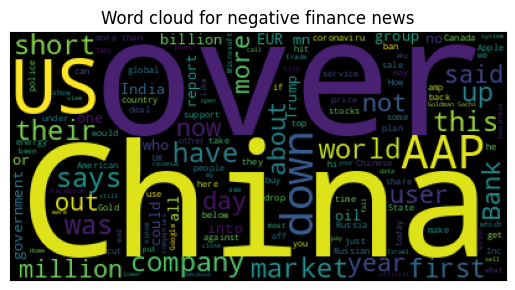

In [170]:
# Word cloud
from wordcloud import WordCloud

# Don't display common words of either classes
stopwords: list[str] = [
    "new", "will", "stock", "to", "in", "and", "the", "for", "an", "be",
    "of", "on", "a", "it", "i", "as", "is", "by", "with", "has", "but",
    "that", "from", "after", "at", "its", "say", "ha", "are", "u", "s", "wa"
]

word_cloud = WordCloud(stopwords=stopwords).generate(" ".join(X[X.sentiment == "negative"].text))
plt.title("Word cloud for negative finance news")
plt.xticks([])  
plt.yticks([])
plt.imshow(word_cloud)

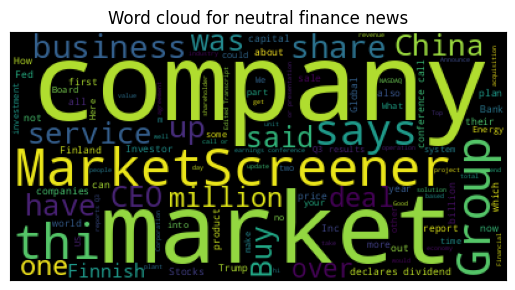

In [171]:
word_cloud = WordCloud(stopwords=stopwords).generate(" ".join(X[X.sentiment == "neutral"].text))
plt.title("Word cloud for neutral finance news")
plt.xticks([])  
plt.yticks([])
plt.imshow(word_cloud)

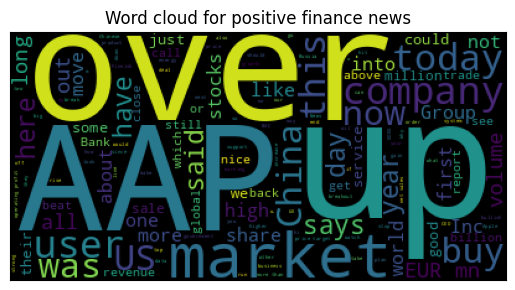

In [172]:
word_cloud = WordCloud(stopwords=stopwords).generate(" ".join(X[X.sentiment == "positive"].text))
plt.title("Word cloud for positive finance news")
plt.xticks([])  
plt.yticks([])
plt.imshow(word_cloud)

### Expand Contractions

In [110]:
from pycontractions import Contractions

path_to_model: str = "/kaggle/input/googlenewsvectors/GoogleNews-vectors-negative300.bin"

# Contractions object initialization takes a bit of time...  
contractions: Contractions = Contractions(path_to_model)
contractions.load_models()

In [111]:
import contractions as contractions_counter

# Contractions expansion takes time too...
print("Expanding contractions...")
X.text = X.text.apply(lambda x: list(contractions.expand_texts([x], precise=True))[0])

X.text.sample(10)

Expanding contractions...


3264    KEX made awesome move thru 7.00 to 7.09 made n...
1521    McDonalds torched hundreds arrested in May Day...
1664    Marrone Bio Innovations : Control Invasive Mus...
4658    Finnish Scanfil , a systems supplier and contr...
4757       it is okay Greg, your insurance will cover it.
850     Kellogg sees 2020 adj. currency-neutral EPS do...
64      Fannie Mae, Freddie Mac downgraded to sell, as...
4104    The copying , republication or redistribution ...
772     Natural Gas Finally Starting To Buckle Against...
3630    In banking , Sampo A was unchanged at 14.24 eu...
Name: text, dtype: object

In [113]:
# Make final dataset downloadable
path: str = "/kaggle/working/dataset.csv"
X.to_csv(path, index=False)

In [114]:
# Encode labels from string to integer
X["sentiment"] = X["sentiment"].map({
    'negative': 0,
    'neutral' : 1,
    'positive': 2
})

# Extract labels
Y: Series = X.pop("sentiment")

Y.sample(5)

3013     0
2114     0
9307     2
1816     1
11690    2
Name: sentiment, dtype: int64

In [115]:
# Get the number of unique words in all the texts
def get_vocab_size(strings: Series) -> int:
    unique_words: set[str] = set()
    for string in strings:
        for word in string.split():
            unique_words.add(word)
    return len(unique_words)


vocab_size: int = get_vocab_size(X.squeeze())
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 68615


In [116]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(
    X,
    Y,
    test_size=0.25
)

print(f"X_train length: {len(X_train)}")
print(f"Y_train length: {len(Y_train)}")
print(f"X_val length: {len(X_val)}")
print(f"Y_val length: {len(Y_val)}")

X_train length: 22405
Y_train length: 22405
X_val length: 7469
Y_val length: 7469


## Model Building

### Neural Network Definition

In [117]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

sequence_length = 64

vectorize_layer = keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    name="text-vectorization"
)

vectorize_layer.adapt(X_train)

In [118]:
import tensorflow as tf
from keras import Sequential
from keras.src.layers import Conv1D, Dense, Dropout, Embedding, InputLayer, GlobalMaxPooling1D

embedding_dim = 128

model = Sequential([
    InputLayer((1,), dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, embedding_dim, name="embedding"),
    Dropout(0.3, name="dropout-1"),
    Conv1D(64, 5, padding="valid", activation="relu", strides=3, name="conv-1d"),
    GlobalMaxPooling1D(name="global-max-pooling-1d"),
    Dense(32, activation="relu", name="dense"),
    Dropout(0.3, name="dropout-2"),
    Dense(3, activation="softmax", name="output")
], name="finance-news-sentiments-classifier")

model.summary()

Model: "finance-news-sentiments-classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text-vectorization              │ (None, 64)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 64, 128)        │     8,782,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout-1 (Dropout)             │ (None, 64, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv-1d (Conv1D)                │ (None, 20, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global-max-pooling-1d           │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout-2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,825,923 (33.67 MB)

 Trainable params: 8,825,923 (33.67 MB)

 Non-trainable params: 0 (0.00 B)

### Fitting

In [119]:
from keras.src.callbacks import History

epochs = 10

model.compile(
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
    optimizer="adam",
)

history: History = model.fit(
    X_train,
    Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs
)

Epoch 1/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.0279 - sparse_categorical_accuracy: 0.4396 - val_loss: 0.7534 - val_sparse_categorical_accuracy: 0.6668
Epoch 2/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.5406 - sparse_categorical_accuracy: 0.7928 - val_loss: 0.7828 - val_sparse_categorical_accuracy: 0.6634
Epoch 3/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2154 - sparse_categorical_accuracy: 0.9321 - val_loss: 1.0385 - val_sparse_categorical_accuracy: 0.6471
Epoch 4/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0828 - sparse_categorical_accuracy: 0.9756 - val_loss: 1.2649 - val_sparse_categorical_accuracy: 0.6417
Epoch 5/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0456 - sparse_categorical_accuracy: 0.9879 - val_loss: 1.5426 - val_sparse_categorical_accuracy: 0.6448
Epoch 6/10
701/701 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0224 - sparse_categorical_accuracy: 0.9941 - val_loss: 1.7083 - val_sparse_categorical_accuracy: 0.6417
Epoc

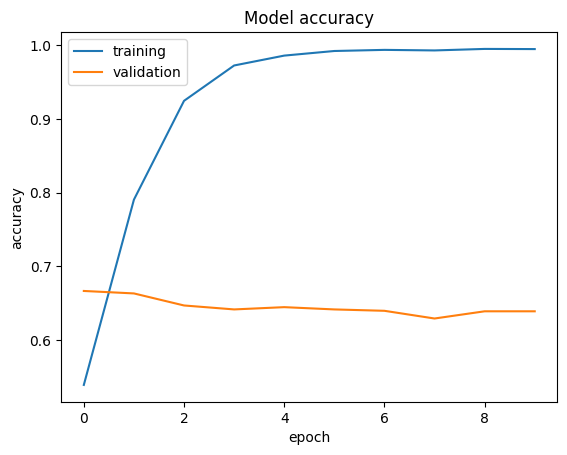

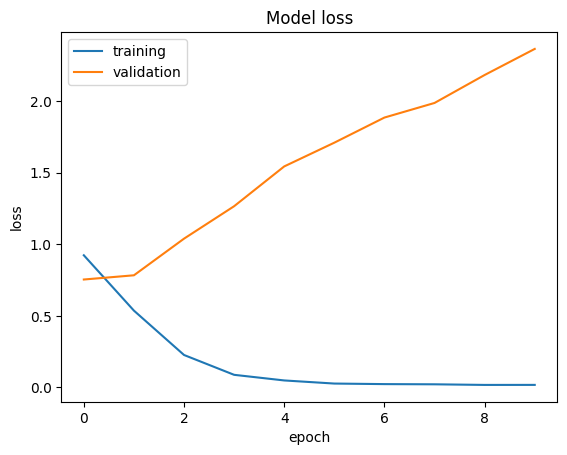

In [120]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


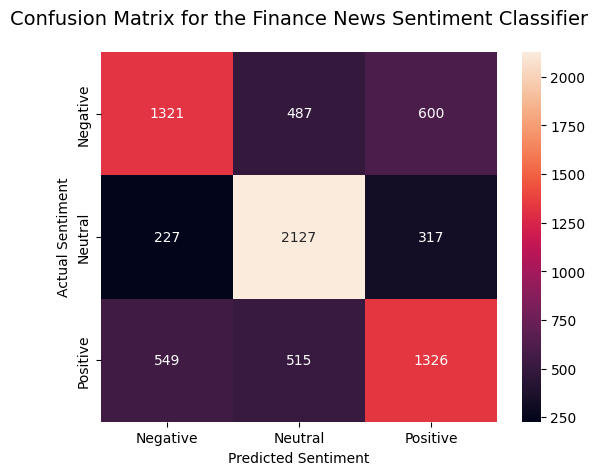

In [121]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

Y_pred = np.argmax(model.predict(X_val), axis=1)

conf_matrix = confusion_matrix(Y_val, Y_pred)

ax = sns.heatmap(conf_matrix, annot=True, fmt="d")
ax.set_xlabel("Predicted Sentiment")
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Actual Sentiment")
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_title("Confusion Matrix for the Finance News Sentiment Classifier", fontsize=14, pad=20)
plt.show()